### Importing Required Libraries and Modules

In this cell, we import various libraries and modules that are essential for our project. These include:

- `torch` and its submodules for building and training neural networks.
- `torchvision` and its submodules for handling image data and transformations.
- `matplotlib.pyplot` for visualizing data.
- `tqdm` for displaying progress bars.
- `timeit` for measuring execution time.
- `PIL` for image processing.
- `os` for file operations.
- `numpy` for numerical operations.
- `pathlib` for handling file paths.
- `pandas` for data manipulation.
- `kagglehub` for downloading datasets from Kaggle.
```

In [97]:
! pip install torchinfo
! pip install torchmetrics
! pip install mlxtend

  Using cached mlxtend-0.23.3-py3-none-any.whl.metadata (7.3 kB)
Using cached mlxtend-0.23.3-py3-none-any.whl (1.4 MB)


In [55]:
# Import Pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader
# Import TorchVision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
# Matplotlib for visualization
import matplotlib.pyplot as plt

# Helper Functions
from tqdm.auto import tqdm
from timeit import default_timer as timer

from PIL import Image, ImageOps
import numpy as np
from pathlib import Path
import pandas as pd
import kagglehub
import os


In [56]:
# Device Agnostic Code
device = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'mps'

In [57]:
# Download latest version of "ninadaithal/imagesoasis"
DIR_PATH = kagglehub.dataset_download("ninadaithal/imagesoasis")+'/Data'
DIR_PATH = Path(DIR_PATH)
print("Path to dataset files:", DIR_PATH)

Path to dataset files: /Users/arjein/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data


In [58]:
# Explore the Directory
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')
# Explore Directories
walk_through_dir(DIR_PATH)

There are 4 directories and 0 images in /Users/arjein/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data
There are 0 directories and 5002 images in /Users/arjein/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data/Mild Dementia
There are 0 directories and 13725 images in /Users/arjein/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data/Very mild Dementia
There are 0 directories and 488 images in /Users/arjein/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data/Moderate Dementia
There are 0 directories and 67222 images in /Users/arjein/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data/Non Demented


# Exploratory Data Analysis

In this section, we will explore the dataset to understand its structure and characteristics. We will look at the number of images, their distribution across different classes, and visualize some sample images. This will help us gain insights into the data and prepare it for further processing and model training.

In [59]:
# Create a list contains every path to '*.jpg' files including non-dementia mild, etc...
image_path_list = list(DIR_PATH.glob("*/*.jpg"))
data_length = len(image_path_list)

# Print the Number of Data samples
print(f'Number of Data Sampels {data_length}')

Number of Data Sampels 86437


In [60]:
# Split the paths to training and test sets. We will need them while we are creating our train and test datasets.
from sklearn.model_selection import train_test_split
train_paths, test_paths = train_test_split(image_path_list, test_size=0.2, random_state=42)
print(f'Number of samples for Training: {len(train_paths)}\nNumber of samples for Testing: {len(test_paths)}')


Number of samples for Training: 69149
Number of samples for Testing: 17288


(np.float64(-0.5), np.float64(495.5), np.float64(247.5), np.float64(-0.5))

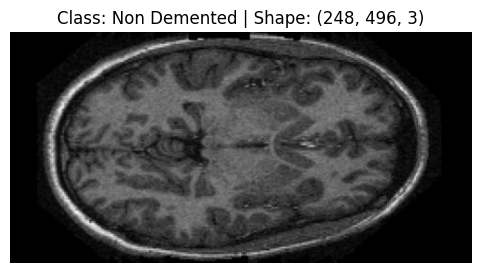

In [61]:
# Visualize a random image
import random
random.seed(42)
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
image = Image.open(random_image_path)

image_as_array = np.asarray(image)
plt.figure(figsize=(6,3))
plt.imshow(image_as_array)
plt.title(f'Class: {image_class} | Shape: {image_as_array.shape}')
plt.axis(False)


### Data Transforming and Preprocessing

In this section, we will transform and preprocess the data to prepare it for training. The transformations include resizing the images, converting them to grayscale, and converting them to tensors. These steps are crucial for ensuring that the data is in the correct format for input into our neural network model.

In [62]:
# Transforming Data
# Before we can use image with pytorch we want to transform them into tensors.
# Turn target data into Tensor.

data_transform = transforms.Compose([
    # Resize images to form 224 x 224 images.
    transforms.Resize(size=(64, 64)),
    # Convert RGB to grayscale as image mainly consists of black and white
    transforms.Grayscale(num_output_channels=1),
    # Turn the image to Tensor
    transforms.ToTensor(),
])


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

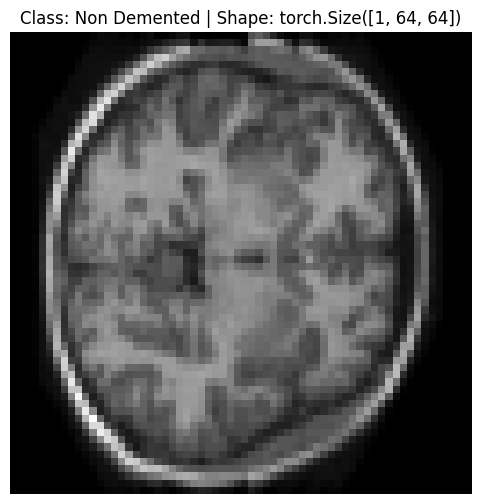

In [63]:
# Look at the Transformed image
img_transformed = data_transform(image)
plt.figure(figsize=(6,6))
plt.imshow(img_transformed.squeeze(), cmap='gray')
plt.title(f'Class: {image_class} | Shape: {img_transformed.shape}')
plt.axis(False)

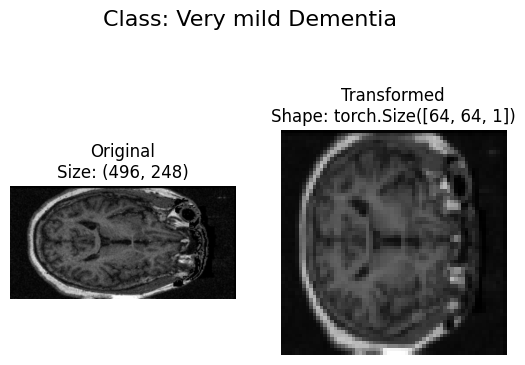

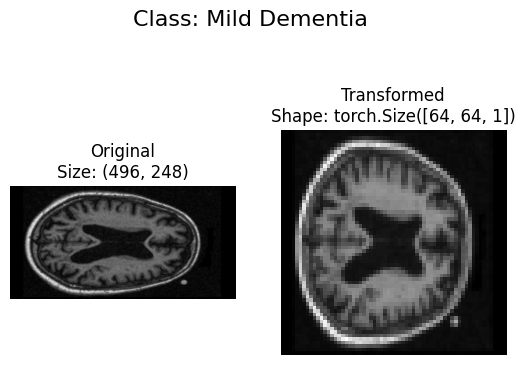

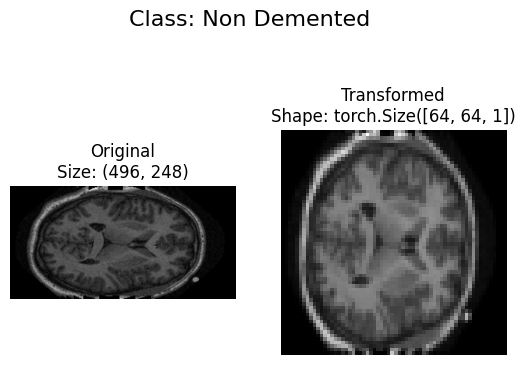

In [64]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            transformed_f = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_f, cmap='gray') # can add cmap='gray'
            ax[1].set_title(f'Transformed\nShape: {transformed_f.shape}')
            ax[1].axis(False)

        fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_path_list,transform=data_transform,seed=None)



In [65]:
# Create custom Dataset
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, paths=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        if paths is not None:
            self.samples = [(p, self.class_to_idx[p.parent.name]) for p in paths]
            self.targets = [s[1] for s in self.samples]

# Create separate ImageFolder instances for training and test sets
train_dataset = CustomImageFolder(root=DIR_PATH, transform=data_transform, paths=train_paths)
test_dataset = CustomImageFolder(root=DIR_PATH, transform=data_transform, paths=test_paths)

print(f'Train Size: {len(train_dataset)} | Test Size: {len(test_dataset)}')


Train Size: 69149 | Test Size: 17288


In [66]:
# Function to count the number of samples per class in a dataset
def count_classes(dataset):
    labels = [label for _, label in dataset]
    labels_tensor = torch.tensor(labels)
    class_counts = torch.bincount(labels_tensor)
    return class_counts

# Calculate the weight parameter for loss optimizer.
WEIGHT_PATH = 'class_weights_ratio.pth'
if os.path.exists(WEIGHT_PATH):
    print('Weights file already exists!\nLoading the Weight ratios...')
    class_weights_ratio = torch.load('class_weights_ratio.pth', weights_only=True, map_location=device)


else:
    # Count classes in train and test datasets
    train_class_counts = count_classes(train_dataset)
    test_class_counts = count_classes(test_dataset)

    print("Train class counts:", train_class_counts)
    print("Test class counts:", test_class_counts)

    class_weights = 1. / train_class_counts.type(torch.float)
    class_weights_ratio = class_weights / class_weights.sum()  # Normalize weights
    torch.save(class_weights_ratio, WEIGHT_PATH)

class_weights_ratio = class_weights_ratio.to(device)
print(class_weights_ratio)

Weights file already exists!
Loading the Weight ratios...
tensor([0.0840, 0.8788, 0.0063, 0.0309], device='mps:0')


In [67]:
#Explore the Class names
class_names = train_dataset.classes
print(class_names)

['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [68]:
# Set batch size to 64
BATCH_SIZE = 32
# Create DataLoaders for both Train and Test datasets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  # Num_workers : os.cpu_count()
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [69]:
# Retrieve and print the shape of an image and its corresponding label from the training dataloader.
img, label = next(iter(train_dataloader))
print(f'Image Shape: {img.shape}, ')
print(f'Label Shape: {label.shape}, ')

Image Shape: torch.Size([32, 1, 64, 64]), 
Label Shape: torch.Size([32]), 


### Creating Model

In this section, we will define and initialize our model.

The model parameters are as follows:
- `in_features`: Number of input channels (1 for grayscale images).
- `hidden_units`: Number of filters in the convolutional layers.
- `out_features`: Number of output classes (4 in our case).

We will also set up the optimizer and loss function for training the model.

In [70]:
class CustomCNNModel(nn.Module):
  def __init__(self, in_features, hidden_units, out_features):
      super().__init__()
      self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
           in_channels=in_features,
           out_channels=hidden_units,
           kernel_size=(3,3),
           padding=1,
           stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
           in_channels=hidden_units,
           out_channels=hidden_units,
           kernel_size=(3,3),
           padding=1,
           stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
           kernel_size=2,
           stride=2 # Default Stride size is equal to Kernel Size)
        )
      )
      self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
           in_channels=hidden_units,
           out_channels=hidden_units,
           kernel_size=(3,3),
           padding=1,
           stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
           in_channels=hidden_units,
           out_channels=hidden_units,
           kernel_size=(3,3),
           padding=1,
           stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
           kernel_size=2,
           stride=2 # Default Stride size is equal to Kernel Size)
        )
      )

      self.clasifier = nn.Sequential(
         nn.Flatten(),
         nn.Linear(
            # Calculate and set in_features, depending on the data shape.
            # As the output of Thrid conv block has a shape of  torch.Size([32, 64, 28, 28]).
            # We will simply multiply in_features value with 28 * 28.
            in_features=hidden_units * 16 * 16,
            out_features=out_features,
          )
      )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    #print(f'Input Shape : {x.shape}')
    x = self.conv_block_1(x)
    #print(f'After First Conv Block Shape : {x.shape}')
    x = self.conv_block_2(x)
    #print(f'After Second Conv Block Shape : {x.shape}')
    x = self.clasifier(x)
    #print(f'After Classifier Shape : {x.shape}')
    return x



In [71]:
# Set custom model parameters. Can be Fine-Tuned.
custom_model_parameters = {'in_features' : 1,
                         'hidden_units' : 16,
                         'out_features' : len(class_names),
                         'lr': 0.001
                         }

In [72]:
custom_cnn_model = CustomCNNModel(
    in_features=custom_model_parameters['in_features'],
    hidden_units=custom_model_parameters['hidden_units'],
    out_features=custom_model_parameters['out_features']
)


In [ ]:
# Explore The Summary of Our Model
from torchinfo import summary
summary(model=custom_cnn_model, input_size=(BATCH_SIZE,1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNNModel                           [32, 4]                   --
├─Sequential: 1-1                        [32, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 16, 64, 64]          160
│    └─ReLU: 2-2                         [32, 16, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 16, 64, 64]          2,320
│    └─ReLU: 2-4                         [32, 16, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 16, 32, 32]          --
├─Sequential: 1-2                        [32, 16, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 16, 32, 32]          2,320
│    └─ReLU: 2-7                         [32, 16, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 16, 32, 32]          2,320
│    └─ReLU: 2-9                         [32, 16, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 16, 16, 16]          --
├─Seq

In [74]:
# Make a dummy prediction with Untrained Model on a batch to see if it works.
def test_model_on_dummy_data(model, X, y):
    model = model.to(device)
    X = X.to(device)
    y = y.to(device)
    y_logit = model(X)
    y_prob = torch.softmax(y_logit, dim=0)
    y_label = y_prob.argmax(dim=1)
    return y_label , y

print( 'X:', img.shape,'Dummy Label:', label.shape)
dummy_pred, dummy_label = test_model_on_dummy_data(custom_cnn_model, img, label)
print(f'Predicted Label: {dummy_pred}')
print(f'True Label: {dummy_pred}')

X: torch.Size([32, 1, 64, 64]) Dummy Label: torch.Size([32])
Predicted Label: tensor([2, 1, 0, 0, 3, 0, 3, 2, 1, 1, 2, 1, 1, 3, 2, 1, 0, 2, 1, 3, 3, 0, 2, 1,
        3, 0, 3, 2, 1, 0, 3, 0], device='mps:0')
True Label: tensor([2, 1, 0, 0, 3, 0, 3, 2, 1, 1, 2, 1, 1, 3, 2, 1, 0, 2, 1, 3, 3, 0, 2, 1,
        3, 0, 3, 2, 1, 0, 3, 0], device='mps:0')


In [75]:
# Train Step
def train_step(model, data, loss_fn, optimizer, device=device):
  model.to(device)
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(data):
    # Device Agnostic
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_logits = model(X)


    # Calculate the Loss and Acc
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    # 3. Set optimizer Gradient to Zero
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # Optimizer Step
    optimizer.step()

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

    train_acc += (y_pred == y).sum().item() / len(y_pred)

    if batch % 200 == 0:
      print(f'Looked at {batch * len(X)} /{len(data.dataset)} samples!')

  train_loss /= len(data)
  train_acc /= len(data)

  print(f'Train Loss: {train_loss} | Train Acc: {train_acc * 100}%')
  return train_loss, train_acc

# Test Step
def test_step(model, data, loss_fn, device=device):
  model = model.to(device)
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data):
      X, y = X.to(device), y.to(device)

      # Forward Pass
      y_logits = model(X)

      # Pred
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

      # Calculate the Loss and Acc
      test_loss += loss_fn(y_logits, y).item()
      test_acc += (y_pred == y).sum().item() / len(y_pred)


    test_loss /= len(data)
    test_acc /= len(data)
    print(f'Test Loss: {test_loss} | Test Acc: {test_acc * 100}%')
    return test_loss, test_acc




In [76]:
def print_train_time(start: float, end : float, device: torch.device = device):
        total_time = end - start
        print(f'Train time on {device}: {total_time:.3f} seconds')
        return total_time

In [77]:
# Use the class_weights_ratio we calculated before to cope with the imbalanced dataset.
# Declare The Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss(
    weight=class_weights_ratio
    )

optim = torch.optim.Adam(custom_cnn_model.parameters(), lr= custom_model_parameters['lr'])

In [78]:
# Create a Training loop

def train_model(epochs: int,
                model: nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn : nn.Module,
                optimizer= torch.optim,
                device=device,
                seed=int):

  torch.manual_seed(seed)
  torch.mps.manual_seed(seed)

  evaluation_results = {
    'train_loss' :[],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
  }

  print(f'Training on Device {device}')
  train_time_start = timer()

  for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch}\n------------------')

    train_loss, train_acc = train_step(
        model=model,
        data=train_dataloader,
        loss_fn=loss_fn,
        optimizer= optimizer,
        device=device,
    )
    test_loss, test_acc = test_step(
        model=model,
        data=test_dataloader,
        loss_fn=loss_fn,
        device=device,
      )
    evaluation_results['train_loss'].append(train_loss)
    evaluation_results['train_acc'].append(train_acc)
    evaluation_results['test_loss'].append(test_loss)
    evaluation_results['test_acc'].append(test_acc)

  train_time_end = timer()
  total_train_time = print_train_time(start=train_time_start, end=train_time_end)
  evaluation_results['train_duration'] = total_train_time
  return evaluation_results


In [79]:
# Train for 7 epochs, Can be adjusted.
epochs = 7
custom_cnn_results = train_model(epochs=epochs,
            model=custom_cnn_model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optim,
            device=device,
            seed=42)
custom_cnn_results

Training on Device mps


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0
------------------
Looked at 0 /69149 samples!
Looked at 6400 /69149 samples!
Looked at 12800 /69149 samples!
Looked at 19200 /69149 samples!
Looked at 25600 /69149 samples!
Looked at 32000 /69149 samples!
Looked at 38400 /69149 samples!
Looked at 44800 /69149 samples!
Looked at 51200 /69149 samples!
Looked at 57600 /69149 samples!
Looked at 64000 /69149 samples!
Train Loss: 0.9612906216258034 | Train Acc: 64.23540745823294%


 14%|█▍        | 1/7 [01:14<07:27, 74.59s/it]

Test Loss: 0.5071858606626608 | Test Acc: 78.76617375231054%
Epoch 1
------------------
Looked at 0 /69149 samples!
Looked at 6400 /69149 samples!
Looked at 12800 /69149 samples!
Looked at 19200 /69149 samples!
Looked at 25600 /69149 samples!
Looked at 32000 /69149 samples!
Looked at 38400 /69149 samples!
Looked at 44800 /69149 samples!
Looked at 51200 /69149 samples!
Looked at 57600 /69149 samples!
Looked at 64000 /69149 samples!
Train Loss: 0.3293825051618403 | Train Acc: 84.29371978171025%


 29%|██▊       | 2/7 [02:29<06:13, 74.61s/it]

Test Loss: 0.2296613056587947 | Test Acc: 90.1166820702403%
Epoch 2
------------------
Looked at 0 /69149 samples!
Looked at 6400 /69149 samples!
Looked at 12800 /69149 samples!
Looked at 19200 /69149 samples!
Looked at 25600 /69149 samples!
Looked at 32000 /69149 samples!
Looked at 38400 /69149 samples!
Looked at 44800 /69149 samples!
Looked at 51200 /69149 samples!
Looked at 57600 /69149 samples!
Looked at 64000 /69149 samples!
Train Loss: 0.1826801141851126 | Train Acc: 90.45117003622205%


 43%|████▎     | 3/7 [03:43<04:57, 74.45s/it]

Test Loss: 0.13593414298804432 | Test Acc: 93.10304990757857%
Epoch 3
------------------
Looked at 0 /69149 samples!
Looked at 6400 /69149 samples!
Looked at 12800 /69149 samples!
Looked at 19200 /69149 samples!
Looked at 25600 /69149 samples!
Looked at 32000 /69149 samples!
Looked at 38400 /69149 samples!
Looked at 44800 /69149 samples!
Looked at 51200 /69149 samples!
Looked at 57600 /69149 samples!
Looked at 64000 /69149 samples!
Train Loss: 0.13193764456022877 | Train Acc: 92.8373677575835%


 57%|█████▋    | 4/7 [05:00<03:46, 75.37s/it]

Test Loss: 0.1295253370738762 | Test Acc: 92.00554528650648%
Epoch 4
------------------
Looked at 0 /69149 samples!
Looked at 6400 /69149 samples!
Looked at 12800 /69149 samples!
Looked at 19200 /69149 samples!
Looked at 25600 /69149 samples!
Looked at 32000 /69149 samples!
Looked at 38400 /69149 samples!
Looked at 44800 /69149 samples!
Looked at 51200 /69149 samples!
Looked at 57600 /69149 samples!
Looked at 64000 /69149 samples!
Train Loss: 0.1100833507264201 | Train Acc: 94.07217882844787%


 71%|███████▏  | 5/7 [06:16<02:31, 75.68s/it]

Test Loss: 0.10015765546804704 | Test Acc: 94.07347504621072%
Epoch 5
------------------
Looked at 0 /69149 samples!
Looked at 6400 /69149 samples!
Looked at 12800 /69149 samples!
Looked at 19200 /69149 samples!
Looked at 25600 /69149 samples!
Looked at 32000 /69149 samples!
Looked at 38400 /69149 samples!
Looked at 44800 /69149 samples!
Looked at 51200 /69149 samples!
Looked at 57600 /69149 samples!
Looked at 64000 /69149 samples!
Train Loss: 0.09562721338830087 | Train Acc: 94.88762386506886%


 86%|████████▌ | 6/7 [07:31<01:15, 75.29s/it]

Test Loss: 0.1556412022967105 | Test Acc: 92.17305914972273%
Epoch 6
------------------
Looked at 0 /69149 samples!
Looked at 6400 /69149 samples!
Looked at 12800 /69149 samples!
Looked at 19200 /69149 samples!
Looked at 25600 /69149 samples!
Looked at 32000 /69149 samples!
Looked at 38400 /69149 samples!
Looked at 44800 /69149 samples!
Looked at 51200 /69149 samples!
Looked at 57600 /69149 samples!
Looked at 64000 /69149 samples!
Train Loss: 0.07273858796500449 | Train Acc: 96.06618703027016%


100%|██████████| 7/7 [08:44<00:00, 74.98s/it]

Test Loss: 0.0812616826724429 | Test Acc: 96.59773567467653%
Train time on mps: 524.874 seconds


{'train_loss': [0.9612906216258034,
  0.3293825051618403,
  0.1826801141851126,
  0.13193764456022877,
  0.1100833507264201,
  0.09562721338830087,
  0.07273858796500449],
 'train_acc': [0.6423540745823294,
  0.8429371978171025,
  0.9045117003622205,
  0.9283736775758349,
  0.9407217882844787,
  0.9488762386506886,
  0.9606618703027016],
 'test_loss': [0.5071858606626608,
  0.2296613056587947,
  0.13593414298804432,
  0.1295253370738762,
  0.10015765546804704,
  0.1556412022967105,
  0.0812616826724429],
 'test_acc': [0.7876617375231053,
  0.901166820702403,
  0.9310304990757856,
  0.9200554528650647,
  0.9407347504621072,
  0.9217305914972274,
  0.9659773567467652],
 'train_duration': 524.8743646249641}

### Model Evaluation

In this section, we evaluate the performance of our trained model. We will look at various metrics such as training and testing loss, accuracy, and the confusion matrix to understand how well our model is performing. This will help us identify any areas where the model may be underperforming and make necessary adjustments.

In [83]:
# Save the Model
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = 'pytorch_alzheimer_cnn_model.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Save
print(f'Saving the model to: {MODEL_SAVE_PATH}')
torch.save(obj=custom_cnn_model.state_dict(),f=MODEL_SAVE_PATH)

Saving the model to: models/pytorch_alzheimer_cnn_model.pth


In [84]:
# Plots the evaluation metrics: Loss and Accuracy Curve
def plot_evaluation_metrics(evaluation_results):
    epochs = list(range(1, len(evaluation_results['train_loss']) + 1))

    plt.figure(figsize=(14, 5))

    # Plot training and test loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, evaluation_results['train_loss'], label='Train Loss')
    plt.plot(epochs, evaluation_results['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    # Plot training and test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in evaluation_results['train_acc']], label='Train Accuracy (%)')
    plt.plot(epochs, [acc * 100 for acc in evaluation_results['test_acc']], label='Test Accuracy (%)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Over Epochs')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    plt.show()

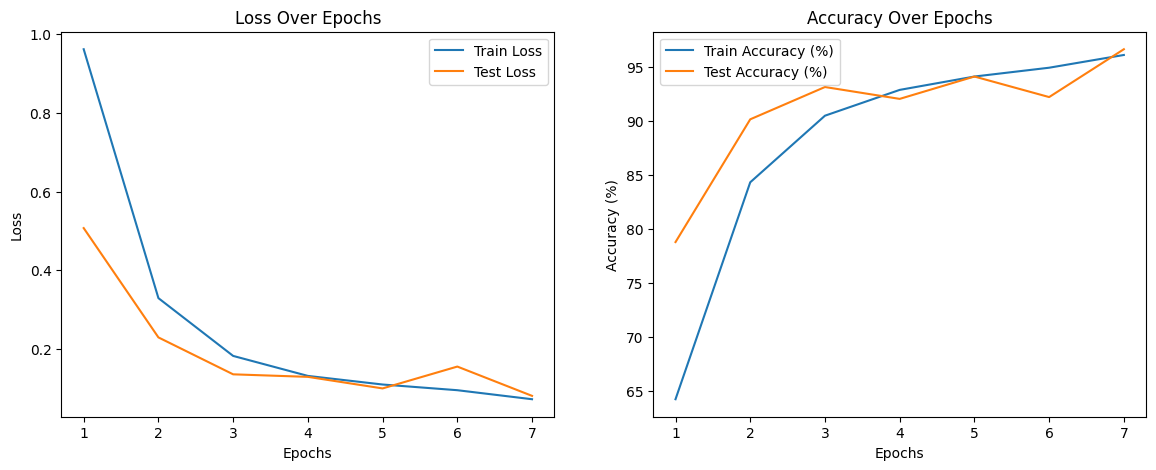

In [85]:
plot_evaluation_metrics(custom_cnn_results)

In [102]:
# Function returns predictions and their corresponding true labels given a dataloader
def get_pred_and_true_labels(model, dataloader, device= device):
    y_preds = []
    model.eval()
    
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc='Making Predictions...'):
            X, y = X.to(device) , y.to(device)
            
            y_logit = model(X)
            
            y_prob = torch.softmax(y_logit, dim=1)
            
            y_label = y_prob.argmax(dim=1)
            
            y_preds.append(y_label.cpu())
            
    
    y_pred_tensor = torch.cat(y_preds) # Concats multiple tensors to one
    print(y_pred_tensor)
    correct = torch.sum(y_pred_tensor == torch.tensor(dataloader.dataset.targets)).item()
    print(f'Accuracy (%): {correct / (len(y_pred_tensor)) * 100}')
    return y_pred_tensor , torch.tensor(dataloader.dataset.targets)
    

In [103]:
# Make Predictions for Confusion Matrix
y_preds, y_trues = get_pred_and_true_labels(custom_cnn_model,dataloader=test_dataloader, device=device)

Making Predictions...: 100%|██████████| 541/541 [00:13<00:00, 41.34it/s]

tensor([2, 2, 2,  ..., 3, 2, 2])
Accuracy (%): 96.59301249421563


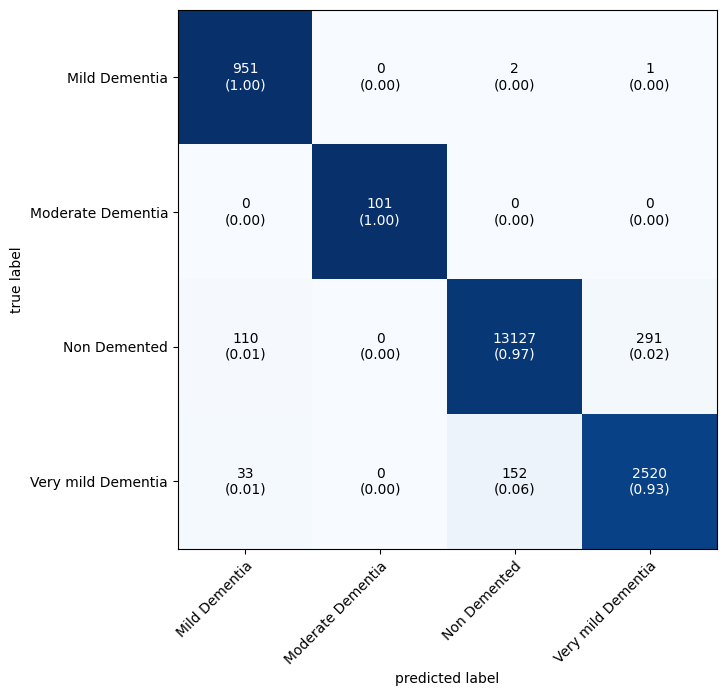

In [ ]:
# Plot The Confusion Matrix
torch.manual_seed(42)
from torchmetrics.classification import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = MulticlassConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds= y_preds, target=y_trues)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), 
                                class_names=class_names,
                                show_normed=True,
                                figsize=(10,7))

In [ ]:
# Load the Saved model For Future Use
torch.manual_seed(42)
loaded_model = CustomCNNModel(input_features=custom_model_parameters['input_features'], hidden_units=custom_model_parameters['hidden_layers'], output_features=custom_model_parameters['output_features'])
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the mdoel to device
loaded_model.to(device)
